<a href="https://www.bigdatauniversity.com"><img src = "https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width = 400, align = "center"></a>

<h1 align=center><font size = 5> Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

### LOADING THE DATASET


In [2]:
import urllib.request
url = 'https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv'
u = urllib.request.urlopen(url)
rawdata = u.read()

In [3]:
localFile = open("loan_train.csv", "wb")
localFile.write(rawdata)
localFile.close()

### Load Data From CSV File  

In [4]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [5]:
print("Shape of data frame: " + str(df.shape))

Shape of data frame: (346, 10)


### Convert to date time object 

In [6]:
df['effective_date']=pd.to_datetime(df['effective_date'], errors = 'coerce')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,10/8/2016,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class (PAIDOFF and COLLECTION) is in our data set 

In [7]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

For each age, show how much PAIDOFF and how much COLLECTION.

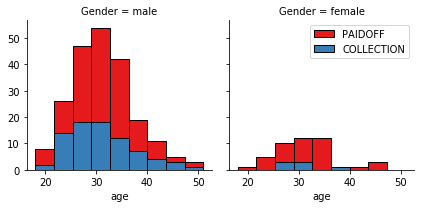

In [8]:
import seaborn as sns
bins=np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# FEATURE SELECTION

### Add column dayofweek to look at the day of the week people get the loan 

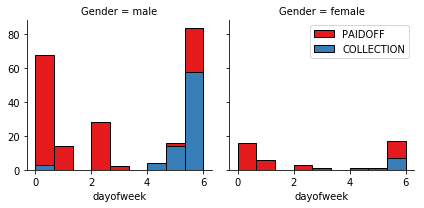

In [9]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins=np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

We see that people who get the loan at the end of the week dont pay it off, so let's use feature binarization to set a threshold values less then day 4 

In [10]:
df['weekend']= df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,10/7/2016,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,10/7/2016,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,9/22/2016,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,10/8/2016,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,10/8/2016,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [11]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [12]:
df['Gender'] = df['Gender'].apply(lambda x: 0 if (x == "male")  else 1)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,10/7/2016,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,10/7/2016,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,9/22/2016,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,10/8/2016,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,10/8/2016,29,college,0,4,1


#### What about education?

In [13]:
df.groupby(['education'])['loan_status'].value_counts()

education             loan_status
Bechalor              PAIDOFF         33
                      COLLECTION      11
High School or Below  PAIDOFF        112
                      COLLECTION      39
Master or Above       COLLECTION       1
                      PAIDOFF          1
college               PAIDOFF        114
                      COLLECTION      35
Name: loan_status, dtype: int64

In [14]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Make new dataframe with only needed columns for prediction and turn education (categorical) into dummy variables, removing master and above since very little occurencies

In [15]:
new_df=df[['Principal','terms','age','Gender','weekend']]
new_df=pd.concat([new_df,pd.get_dummies(df['education'])], axis=1)
new_df.drop(['Master or Above'], axis = 1,inplace=True)

In [16]:
new_df.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


store labels in y (0 = PAIDOFF, 1 = COLLECTION)

In [17]:
df['loan_status']= df['loan_status'].apply(lambda x: 0 if (x == "PAIDOFF")  else 1)
y = df['loan_status'].values
y[0:5]

array([0, 0, 0, 0, 0])

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [18]:
new_df= preprocessing.StandardScaler().fit(new_df).transform(new_df)
new_df[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You can find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(new_df, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


In [20]:
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier

In [21]:
for k in range(3,15):
    knn = KNeighborsClassifier(n_neighbors=k).fit(X_train,y_train)
    yhat = knn.predict(X_test)
    print("k = " + str(k) + " -> f1 score = " + str(f1_score(y_test, yhat, average = "weighted")))

k = 3 -> f1 score = 0.714285714286
k = 4 -> f1 score = 0.72380952381
k = 5 -> f1 score = 0.754049616119
k = 6 -> f1 score = 0.733424470267
k = 7 -> f1 score = 0.776654024442
k = 8 -> f1 score = 0.72380952381
k = 9 -> f1 score = 0.746874561034
k = 10 -> f1 score = 0.714285714286
k = 11 -> f1 score = 0.696178937558
k = 12 -> f1 score = 0.667052246
k = 13 -> f1 score = 0.687315634218
k = 14 -> f1 score = 0.677295918367


So I choose k = 7

# Decision Tree

In [22]:
from sklearn.tree import DecisionTreeClassifier
DT = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
DT.fit(X_train,y_train)
DT

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [23]:
yhat = DT.predict(X_test)
yhat

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0])

# Support Vector Machine

In [24]:
from sklearn import svm
SVM = svm.SVC()
SVM.fit(X_train, y_train) 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [25]:
yhat = SVM.predict(X_test)
yhat

array([1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0])

# Logistic Regression

In [26]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(C=0.01).fit(X_train,y_train)
LR

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [27]:
yhat = LR.predict(X_test)
yhat

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0])

# Model Evaluation using Test set

In [28]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import log_loss

download and load the test set:

In [29]:
rl = "https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv"
u = urllib.request.urlopen(url)
rawdata = u.read()

In [30]:
localFile = open("loan_test.csv", "wb")
localFile.write(rawdata)
localFile.close()

### Load Test set for evaluation 

In [31]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [32]:
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'], errors = 'coerce')
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df['Gender'] = test_df['Gender'].apply(lambda x: 0 if (x == "male")  else 1)
test_df_new = test_df[['Principal','terms','age','Gender','weekend']]
test_df_new = pd.concat([test_df_new,pd.get_dummies(test_df['education'])], axis=1)
test_df_new.drop(['Master or Above'], axis = 1,inplace=True)
test_X = preprocessing.StandardScaler().fit(test_df_new).transform(test_df_new)
test_X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

In [33]:
test_df['loan_status']= test_df['loan_status'].apply(lambda x: 0 if (x == "PAIDOFF")  else 1)
test_y = test_df['loan_status'].values
test_y[0:5]

array([0, 0, 0, 0, 0])

In [34]:
knn_yhat = knn.predict(test_X)
print("KNN Jaccard index: %.2f" % jaccard_similarity_score(test_y, knn_yhat))
print("KNN F1-score: %.2f" % f1_score(test_y, knn_yhat, average='weighted') )

KNN Jaccard index: 0.75
KNN F1-score: 0.72


In [35]:
DT_yhat = DT.predict(test_X)
print("DT Jaccard index: %.2f" % jaccard_similarity_score(test_y, DT_yhat))
print("DT F1-score: %.2f" % f1_score(test_y, DT_yhat, average='weighted') )

DT Jaccard index: 0.75
DT F1-score: 0.65


In [36]:
SVM_yhat = SVM.predict(test_X)
print("SVM Jaccard index: %.2f" % jaccard_similarity_score(test_y, SVM_yhat))
print("SVM F1-score: %.2f" % f1_score(test_y, SVM_yhat, average='weighted') )

SVM Jaccard index: 0.77
SVM F1-score: 0.76


In [37]:
LR_yhat = LR.predict(test_X)
LR_yhat_prob = LR.predict_proba(test_X)
print("LR Jaccard index: %.2f" % jaccard_similarity_score(test_y, LR_yhat))
print("LR F1-score: %.2f" % f1_score(test_y, LR_yhat, average='weighted') )
print("LR LogLoss: %.2f" % log_loss(test_y, LR_yhat_prob))

LR Jaccard index: 0.74
LR F1-score: 0.72
LR LogLoss: 0.56


# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | 0.75       | 0.72        | NA      |
| Decision Tree      | 0.75       | 0.65        | NA      |
| SVM                | 0.77      | 0.66       | NA      |
| LogisticRegression |0.74      | 0.72        | 0.56       |

## Want to learn more?

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: [SPSS Modeler](http://cocl.us/ML0101EN-SPSSModeler).

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at [Watson Studio](https://cocl.us/ML0101EN_DSX)


<hr>
Copyright &copy; 2018 [Cognitive Class](https://cocl.us/DX0108EN_CC). This notebook and its source code are released under the terms of the [MIT License](https://bigdatauniversity.com/mit-license/).​

### Thanks for completing this lesson!

Notebook created by: <a href = "https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>